In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
import shutil
import random
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
import cv2

In [15]:
import shutil
import os

seatbelt_extract_path = '/kaggle/input/vehant-dataset/RESIZEDBILATERALSEATBELTDATASET'
non_seatbelt_extract_path = '/kaggle/input/vehant-dataset/RESIZEDBILATERALNOSEATBELTDATASET'
seatbelt_label = 1
non_seatbelt_label = 0

output_directory = '/kaggle/working/labeled_images'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def label_images(directory, label):
    # Create subdirectory for the class
    class_dir = os.path.join(output_directory, f"class{label}")
    os.makedirs(class_dir, exist_ok=True)
    
    images = os.listdir(directory)
    for image in images:
        image_path = os.path.join(directory, image)
        new_name = f"{label}_{image}"
        new_path = os.path.join(class_dir, new_name)
        shutil.copy(image_path, new_path)
label_images(seatbelt_extract_path, seatbelt_label)
label_images(non_seatbelt_extract_path, non_seatbelt_label)

print("Labeling completed.")


Labeling completed.


## Splitting the data into train-test split.

In [16]:

def split_and_copy_class_images(class_folder, train_folder, test_folder, train_ratio):
    # Create train and test class folders
    train_class_folder = os.path.join(train_folder, os.path.basename(class_folder))
    test_class_folder = os.path.join(test_folder, os.path.basename(class_folder))
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)

    # List images in the class folder
    class_images = os.listdir(class_folder)
    random.shuffle(class_images)

    # Split images into train and test sets
    train_size = int(train_ratio * len(class_images))
    train_images = class_images[:train_size]
    test_images = class_images[train_size:]

    # Copy images to train folder
    for image in train_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(train_class_folder, image))

    # Copy images to test folder
    for image in test_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(test_class_folder, image))

# Define paths
seatbelt_folder = '/kaggle/working/labeled_images/class1'
non_seatbelt_folder = '/kaggle/working/labeled_images/class0'
train_folder = '/kaggle/working/train_data'
test_folder = '/kaggle/working/test_data'

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Split and copy images for seatbelt class
split_and_copy_class_images(seatbelt_folder, train_folder, test_folder, train_ratio=0.7)

# Split and copy images for non-seatbelt class
split_and_copy_class_images(non_seatbelt_folder, train_folder, test_folder, train_ratio=0.7)

print("Dataset split completed.")


Dataset split completed.


In [17]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()  
])
trainset = torchvision.datasets.ImageFolder(root='/kaggle/working/train_data', transform=transform)
testset = torchvision.datasets.ImageFolder(root='/kaggle/working/test_data', transform=transform)


In [18]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        # Calculate the number of input features for the first linear layer
        # The input size is determined by the output size of the last convolutional layer
        self.fc_model = nn.Sequential(
            nn.Linear(64 * 73 * 73, 128),  # Adjusted in_features based on the output size of the last convolutional layer
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x


In [19]:

transform = transforms.Compose([
     transforms.Grayscale(num_output_channels=1),
    transforms.Resize((300, 300)), 
    transforms.ToTensor() 
])
train_data_path = '/kaggle/working/train_data' 
test_data_path = '/kaggle/working/test_data'  
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Test accuracy: 49.6551724137931
Train accuracy: 49.81132075471698


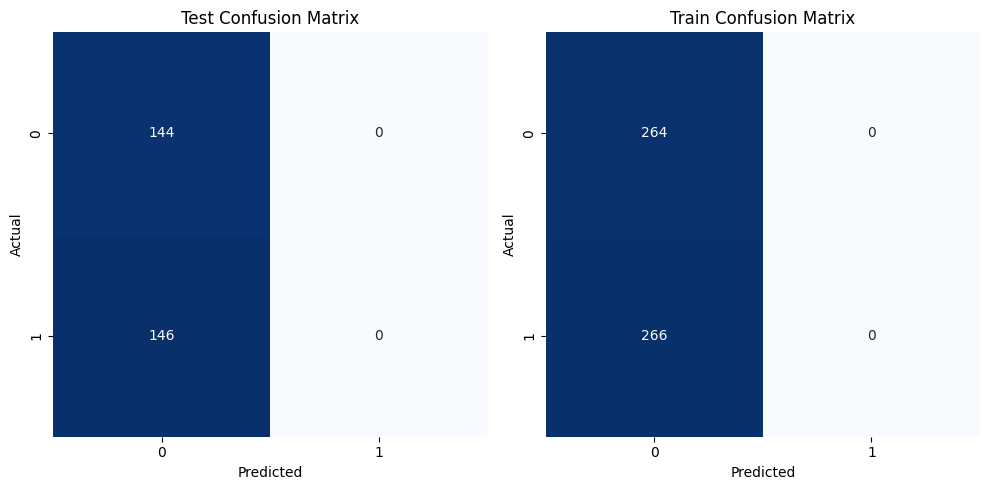

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluation_with_confusion_matrix(dataloader):
    total, correct = 0, 0
    all_preds = []
    all_labels = []
    for data in dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        all_preds.extend(pred.tolist())
        all_labels.extend(labels.tolist())
    accuracy = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, cm




In [21]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
net=ConvNet()


In [23]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 50.34, Train acc: 50.19
Epoch: 1/16, Test acc: 50.34, Train acc: 50.19
Epoch: 2/16, Test acc: 70.00, Train acc: 71.32
Epoch: 3/16, Test acc: 85.52, Train acc: 92.83
Epoch: 4/16, Test acc: 92.41, Train acc: 97.74
Epoch: 5/16, Test acc: 92.07, Train acc: 99.81
Epoch: 6/16, Test acc: 92.76, Train acc: 100.00
Epoch: 7/16, Test acc: 92.41, Train acc: 100.00
Epoch: 8/16, Test acc: 92.41, Train acc: 100.00
Epoch: 9/16, Test acc: 92.41, Train acc: 100.00
Epoch: 10/16, Test acc: 92.41, Train acc: 100.00
Epoch: 11/16, Test acc: 92.76, Train acc: 100.00
Epoch: 12/16, Test acc: 92.41, Train acc: 100.00
Epoch: 13/16, Test acc: 92.76, Train acc: 100.00
Epoch: 14/16, Test acc: 92.41, Train acc: 100.00
Epoch: 15/16, Test acc: 92.76, Train acc: 100.00


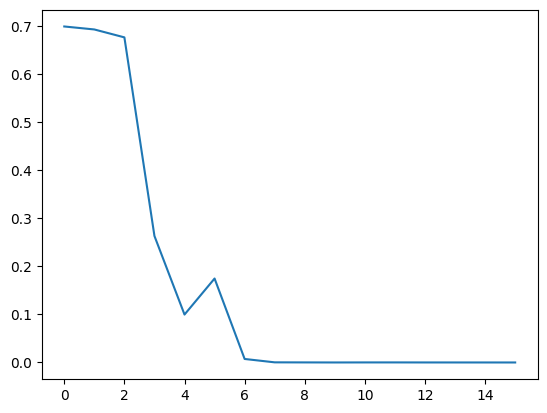

CPU times: user 40min 18s, sys: 21min 50s, total: 1h 2min 8s
Wall time: 31min 50s


In [24]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16
for epoch in range(max_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(test_loader), evaluation(train_loader)))
plt.plot(loss_epoch_arr)
plt.show()

Test accuracy: 92.75862068965517
Train accuracy: 100.0


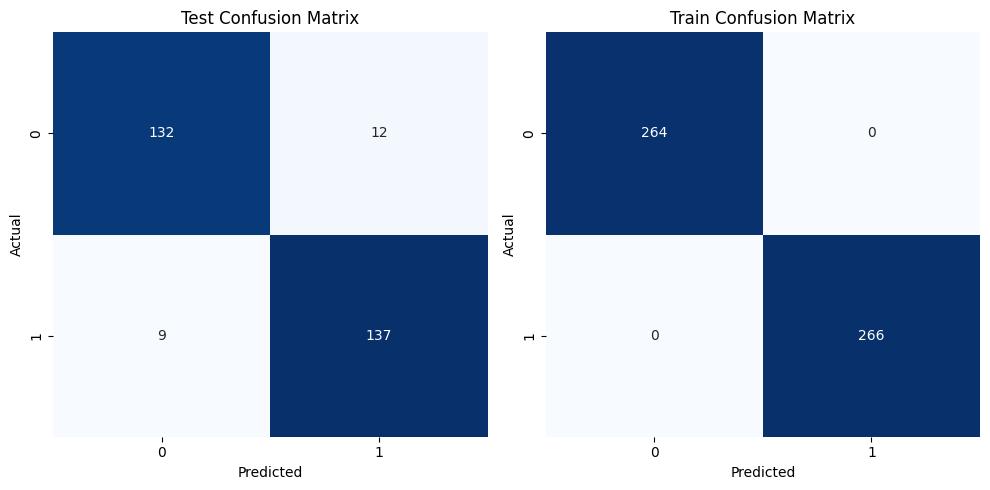

In [26]:
test_accuracy, test_confusion_matrix = evaluation_with_confusion_matrix(test_loader)
train_accuracy, train_confusion_matrix = evaluation_with_confusion_matrix(train_loader)
print('Test accuracy:', test_accuracy)
print('Train accuracy:', train_accuracy)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
sns.heatmap(train_confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
#!rm -rf /kaggle/working/*